In [1]:
# Import Libraries

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import os


In [7]:
# call the yfinance API to get the stock data for the stock codes

# Get the stock codes from the 'Code' column of your DataFrame
symbol = "D05.SI"

# DataFrame to store all the data
RealAssets_data = pd.DataFrame()

data = yf.download(symbol, start='2000-01-01', end=datetime.now())
# data['Symbol'] = symbol  # Add a column for the stock symbol
RealAssets_data = pd.concat([RealAssets_data, data])

RealAssets_data.info()

[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6024 entries, 2000-01-03 to 2024-01-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6024 non-null   float64
 1   High       6024 non-null   float64
 2   Low        6024 non-null   float64
 3   Close      6024 non-null   float64
 4   Adj Close  6024 non-null   float64
 5   Volume     6024 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 329.4 KB


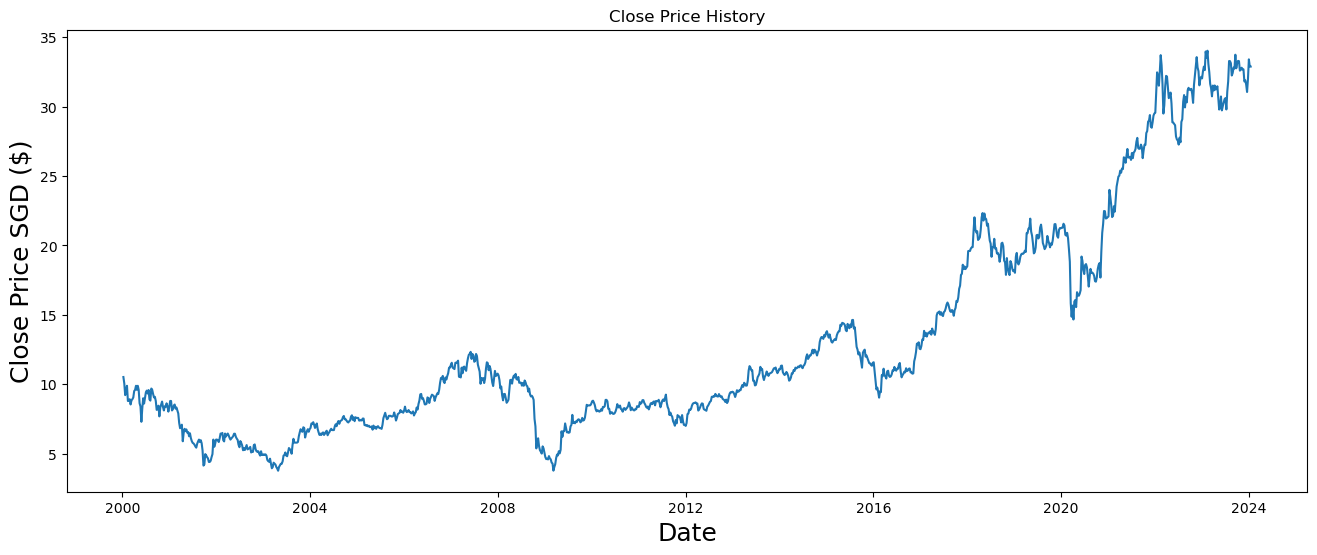

In [8]:
# Ensure your index is a DateTimeIndex
RealAssets_data.index = pd.to_datetime(RealAssets_data.index)

# Resample to weekly frequency, taking the last price each week
weekly_data = RealAssets_data['Adj Close'].resample('W').last()

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(weekly_data)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price SGD ($)', fontsize=18)
plt.show()

In [4]:
# Create a new dataframe with only the 'Close column 
data = RealAssets_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

540

In [5]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.04477608],
       [0.20149254],
       [0.27611934],
       [0.38059703],
       [0.30597005],
       [0.47761187],
       [0.47014919],
       [0.47014919],
       [0.38059703],
       [0.33582077],
       [0.39552239],
       [0.38059703],
       [0.37313435],
       [0.38059703],
       [0.37313435],
       [0.34328345],
       [0.36567167],
       [0.40298507],
       [0.41044775],
       [0.38805971],
       [0.35820881],
       [0.40298507],
       [0.39552239],
       [0.36567167],
       [0.37313435],
       [0.39552239],
       [0.38059703],
       [0.40298507],
       [0.44776115],
       [0.41044775],
       [0.42537311],
       [0.40298507],
       [0.41044775],
       [0.40298507],
       [0.39552239],
       [0.41791043],
       [0.41044775],
       [0.40298507],
       [0.38059703],
       [0.37313435],
       [0.38805971],
       [0.35074613],
       [0.33582077],
       [0.35820881],
       [0.35820881],
       [0.35074613],
       [0.38059703],
       [0.380

In [6]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.04477608, 0.20149254, 0.27611934, 0.38059703, 0.30597005,
       0.47761187, 0.47014919, 0.47014919, 0.38059703, 0.33582077,
       0.39552239, 0.38059703, 0.37313435, 0.38059703, 0.37313435,
       0.34328345, 0.36567167, 0.40298507, 0.41044775, 0.38805971,
       0.35820881, 0.40298507, 0.39552239, 0.36567167, 0.37313435,
       0.39552239, 0.38059703, 0.40298507, 0.44776115, 0.41044775,
       0.42537311, 0.40298507, 0.41044775, 0.40298507, 0.39552239,
       0.41791043, 0.41044775, 0.40298507, 0.38059703, 0.37313435,
       0.38805971, 0.35074613, 0.33582077, 0.35820881, 0.35820881,
       0.35074613, 0.38059703, 0.38059703, 0.35074613, 0.35820881,
       0.35074613, 0.35074613, 0.35820881, 0.32835809, 0.34328345,
       0.35820881, 0.35820881, 0.41044775, 0.43283579, 0.38059703])]
[0.4179104318276723]

[array([0.04477608, 0.20149254, 0.27611934, 0.38059703, 0.30597005,
       0.47761187, 0.47014919, 0.47014919, 0.38059703, 0.33582077,
       0.39552239, 0.38059703, 0.373

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTMCell

# Build the LSTM model
model = Sequential()
model.add(RNN(LSTMCell(128), return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(RNN(LSTMCell(64), return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
480/480 [==============================] - 67s 137ms/step - loss: 0.0085
Epoch 2/2
480/480 [==============================] - 66s 138ms/step - loss: 0.0042


In [8]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1/1 [==============================] - 0s 286ms/step


0.062781987780254

C:\Users\koh46\AppData\Local\Temp\ipykernel_512172\2110294746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


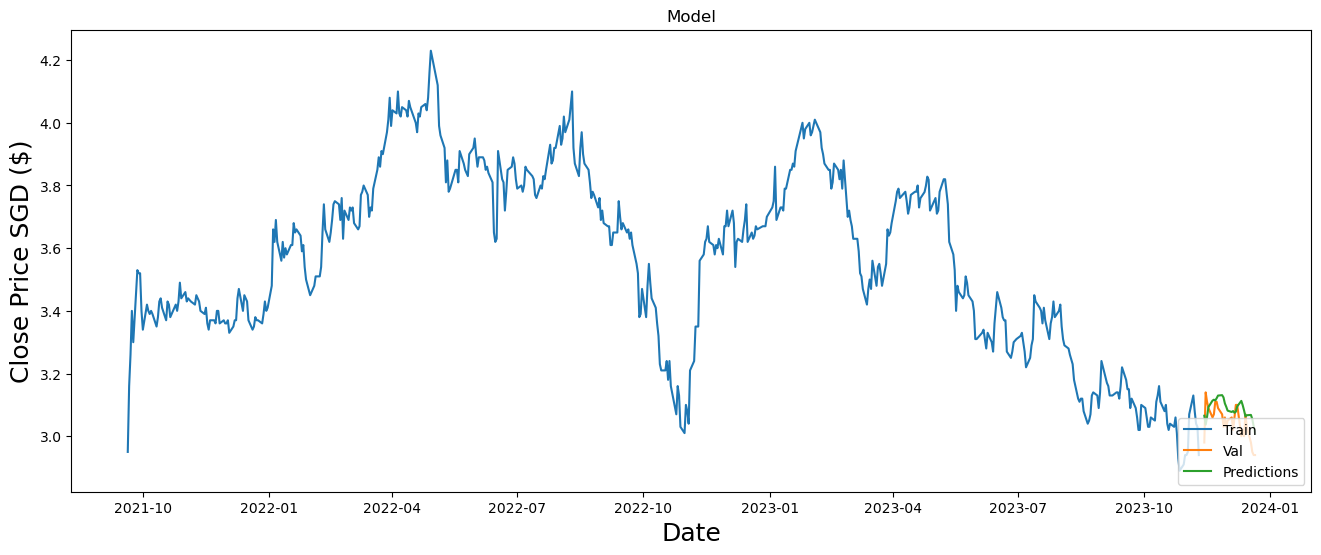

In [9]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price SGD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [10]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-11-14,2.98,3.065494
2023-11-15,3.14,3.036995
2023-11-16,3.11,3.061587
2023-11-17,3.09,3.093052
2023-11-20,3.06,3.113735
2023-11-21,3.07,3.116578
2023-11-22,3.11,3.114312
2023-11-23,3.11,3.121246
2023-11-24,3.09,3.129748


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTMCell
from tensorflow.keras.models import load_model
from tensorflow import function

def download_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

def create_dataset(data):
    data = data.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset, training_data_len

def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def create_training_data(scaled_data, training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    return np.array(x_train), np.array(y_train)

def reshape_data(x_train):
    return np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def build_and_train_model(x_train, y_train):
    model = Sequential()
    model.add(RNN(LSTMCell(128), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(RNN(LSTMCell(64), return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=2)
    return model

def create_test_data(scaled_data, dataset, training_data_len):
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    return np.array(x_test), y_test

def make_predictions(model, x_test, scaler):
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def calculate_rmse(predictions, y_test):
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))

def plot_data(data, training_data_len, predictions):
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid.loc[:, 'Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price SGD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

def save_model(model, model_path):
    model.save(model_path)

def load_model_if_exists(model_path):
    if os.path.exists(model_path):
        return load_model(model_path)
    else:
        return None
# @function
# def predict_with_model(model, x_test):
#     return model.predict(x_test)
# def main():
#     symbol = "9CI.SI"
#     model_path = f"{symbol}_model.h5"
    
#     model = load_model_if_exists(model_path)
    
#     if model is None:
#         data = download_data(symbol, '2020-01-01', datetime.now())
#         dataset, training_data_len = create_dataset(data)
#         scaled_data, scaler = scale_data(dataset)
#         x_train, y_train = create_training_data(scaled_data, training_data_len)
#         x_train = reshape_data(x_train)
#         model = build_and_train_model(x_train, y_train)
#         save_model(model, model_path)
#     x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
#     predictions = make_predictions(model, x_test, scaler)
#     rmse = calculate_rmse(predictions, y_test)
#     print(f'RMSE: {rmse}')
#     plot_data(data, training_data_len, predictions)

# if __name__ == "__main__":
#     main()

[*********************100%%**********************]  1 of 1 completed
6/6 [==============================] - 0s 29ms/step


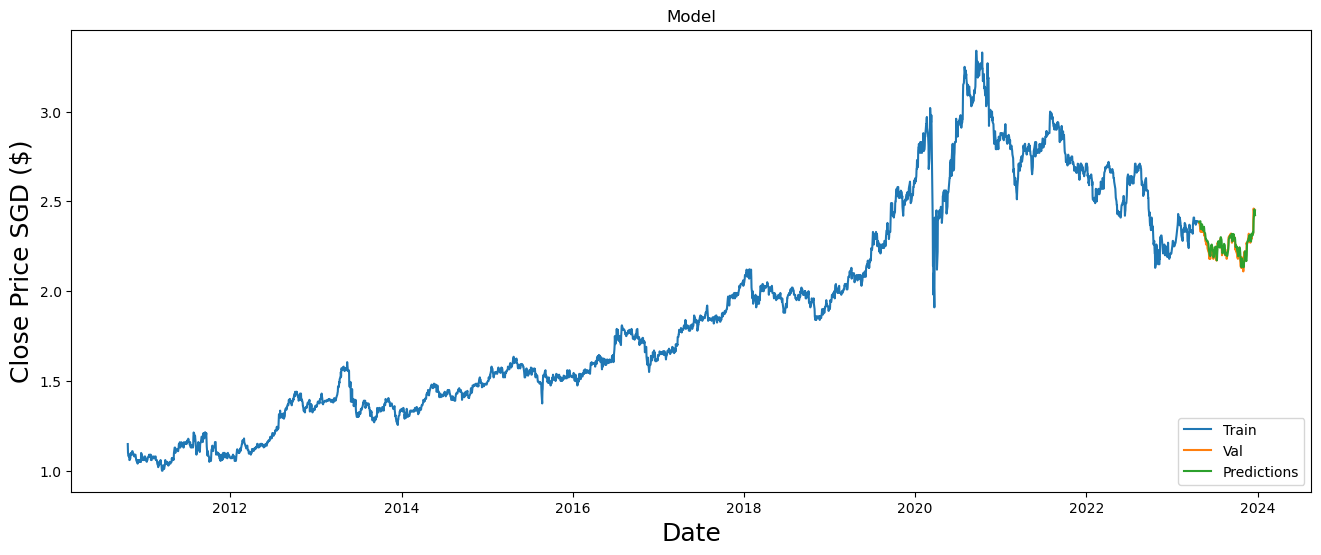

In [12]:
def main():
    symbol = "ME8U.SI"
    model_path = f"models/{symbol}_model.h5"
    
    data = download_data(symbol, '2010-01-01', datetime.now())
    dataset, training_data_len = create_dataset(data)
    scaled_data, scaler = scale_data(dataset)
    
    model = load_model_if_exists(model_path)

    if model is None:
        x_train, y_train = create_training_data(scaled_data, training_data_len)
        x_train = reshape_data(x_train)
        model = build_and_train_model(x_train, y_train)
        save_model(model, model_path)

    
    x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
    predictions = make_predictions(model, x_test, scaler)
    # rmse = calculate_rmse(predictions, y_test)
    # print(f'RMSE: {rmse}')
    plot_data(data, training_data_len, predictions)

if __name__ == "__main__":
    main()